# Euler-Maruyama Integration of SDEs

A stochastic differential equation is a system of $n$ equations of the form


\begin{equation}
\dot{\mathbf{y}} = \mathbf{f}\left(\mathbf{y}\right) + \mathbf{G}\left(t,\mathbf{y}\right)\mathbf{w}\left(t\right),
\end{equation}

where $\mathbf{f}$ is called *drift* (which is equivalent to the right hand side of an ordinary differential equation) and the matrix $\mathbf{G}$ is called *diffusion*, or sometimes *volatility*. The vector $\mathbf{w}$ consists of $n$ uncorrelated white noise processes. There are many processes that are readily modelled by SDEs, such as *Brownian Motion* or *Stock price* evolution.

SDEs can be solved numerically with the *Euler-Maruyama algorithm*, which extends the regular *Euler method* for ODEs with a stochastic term:

\begin{equation}
\mathbf{y}_{i+1} = \mathbf{y}_{i} + \mathbf{f}\left(t_i,\mathbf{y}_i\right)\cdot \Delta t + \mathbf{G}\left(t_i,\mathbf{y}_i\right)\cdot \mathbf{\Delta W}\cdot\sqrt{\Delta t}.
\end{equation}

Here, $\mathbf{\Delta W}$ is a vector consisting of $n$ randomly generated numbers sampled from a gaussian distribution with unit variance.

Note that compared to how the diffusion coefficient was defined in the lecture, a factor $\sqrt{2}$ is missing (different conventions in different fields), so this factor has to be included in the diffusion matrix $\mathbf{G}$, such that for simple Brownian motion in 3d,  $\mathbf{G}$ would be a $3\times 3$ diagonal matrix with entries $G_{ii}=\sqrt{2 D}$. 

SciPy unfortunately does not provide tools for solving SDEs, so we shall implement the algorithm ourselves.

Start by importing *NumPy* and *matplotlib*:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define a function that applies an Euler-Maruyama step:

In [2]:
def em_step(t, y, dt, f, G):
    
    DW = np.random.normal(size=len(y))    
    return y + f(t,y)*dt + np.dot(G(t,y), DW) * np.sqrt(dt)

The single step function is a bit unwieldy, so we create a wrapper that receives a list of times at which the solution should be calculated and outputs the results as an array:

In [3]:
# Params:
#
#    t_list = Sorted np.array with output times
#    y0 = initial state vector
#    dt_max = maximum step size
#    f = drift function (vector)
#    G = diffusion function (matrix)

def eulermaruyama(t_list, y0, dt_max, f, G):
    y_list = np.zeros((len(t_list), len(y0))) # List of results
    
    t = 0 # Current simulation time
    y = y0
    
    for i, T in enumerate(t_list):
        
        while(t < T):            
            # Determine time step. Either dt_max, or shorter to
            # hit the next output point.
            dt = min(T-t, dt_max)
            y = em_step(t, y, dt, f, G)
            t += dt
            
        y_list[i,:] = y
        
    return y_list

Check that everything works by creating a very simple system of $n$ uncoupled particles following a *Geometric Brownian Motion*. The drift shall be

\begin{equation}
\mathbf{f}(\mathbf{y}) = \mathbf{y},
\end{equation}

leading to exponential growth. The diffusion is the diagonal matrix

\begin{equation}
\mathbf{G}(\mathbf{y}) = \frac{1}{10}\text{diag}(\mathbf{y}).
\end{equation}



In [1]:
def f(t,y):
    return y

def G(t,y):
    return 1/10*np.diag(y)

Create 40 particles in 1D starting starting at $y=1$. The simulation runs for $1s$ and outputs every $10ms$:

In [2]:
y0 = np.ones(40)
t = np.linspace(0,1,100)

NameError: name 'np' is not defined

Now, run the simulation with a time step of $dt = 10^{-4}s$ and determine the execution time.

In [6]:
from time import time

dt = 1e-4

begin = time()
y = eulermaruyama(t, y0, dt, f, G)
end = time()

t_python = end - begin

print("Elapsed: %.2fs" % t_python)

Elapsed: 0.25s


You can easily visualize the ensemble:

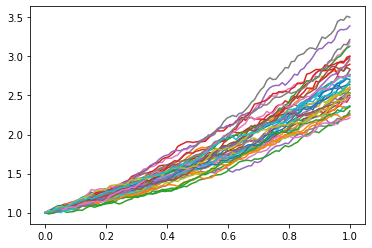

In [7]:
plt.plot(t, y)
plt.show()

## Performance improvement with *numba*

While this code runs somewhat vectorized, it still has quite a lot of *overhead* that is processed by the Python *interpreter*. To get better performance, you need to do the calculations natively on your machine's processor. This is usually done with interfaced Python modules or NumPy extensions, written in *C*.

A less tedious way, more suitable for smaller projects, is the usage of *numba*. *numba* recompiles Python bytecode to native machine code *just-in-time* (meaning on-the-fly during your python script's runtime), supporting NumPy arrays and many of the most common NumPy functions. The rule to avoid Python's `for` iterations does not apply to *numba*, as they will have similar performance to C-style *for*-loops.

To use numba, import `njit`:

In [8]:
from numba import njit

`njit` stands for "*non-python mode / just-in-time*", which means that numba will never call the Python interpreter. This is the preferred way of using numba, yielding the best performance boosts. It's compatibility however is way lesser than *object mode*.

To instruct numba to compile a function, just put the `@njit` decorator in front of the function:

In [9]:
@njit
def em_step(t, y, dt, f, G):
    
    DW = np.zeros(len(y))
    for i, x in np.ndenumerate(DW):
        DW[i] = np.random.normal()
    
    return y + f(t,y)*dt + np.dot(G(t,y), DW) * np.sqrt(dt)

Notice how we changed the creation of the `DW` vector. As of now, numba does not support the `size` parameter of `np.random.normal()`, so we improvise. You can read about the supported features here:

[https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html#distributions](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html#distributions)

The other functions will compile just as they are. Be aware that all functions that are passed to a jitted function have to be jitted as well!

In [10]:
@njit
def eulermaruyama(t_list, y0, dt_max, f, G):
    y_list = np.zeros((len(t_list), len(y0))) # List of results
    t = 0 # Current simulation time
    y = y0
    
    for i, T in enumerate(t_list):
        
        while(t < T):            
            # Determine time step. Either dt_max, or shorter to
            # hit the next output point.
            dt = min(T-t, dt_max)
            y = em_step(t, y, dt, f, G)
            t += dt
            
        y_list[i,:] = y
        
    return y_list

@njit
def f(t,y):
    return y

@njit
def G(t,y):
    return np.diag(y) / 10

Compilation will happen on the first time a decorated function is called. Numba will then determine the data types and produce the appropriate machine code, or abort with an error message.

Run the function to compile it:

In [11]:
y = eulermaruyama(t, y0, dt, f, G)

Run it a second time, to get a useful timing without incorporating the compilation duration:

In [12]:
begin = time()
y = eulermaruyama(t, y0, dt, f, G)
end = time()

t_numba = end - begin

print("Elapsed: %.2fs" % t_numba)
print("Speedup: %.2f" % (t_python / t_numba))

Elapsed: 0.03s
Speedup: 7.47


You should see a significant performance boost - my jitted version ran 4-5 times faster.

If you are interested in using *numba* yourself, make sure to have a look at it's documentation.http://numba.pydata.org/

Numba **is not magic** that makes everything fast by using `njit`. It will require some learning and knowledge to make the most of it. Expect to deal with quite a lot of error messages because of usage of unsupported constructs :-)